In [1]:
from matplotlib import pyplot as plt
from pyppca import ppca
from sklearn import mixture
from sklearn.cluster import SpectralClustering
from operator import itemgetter
import os
from sklearn.decomposition import PCA
import numpy as np
import pickle
import sys
import pandas as pd
import scanpy as sc
from sklearn.metrics import *
data_folder_path = '../../../data'
sys.path.append(data_folder_path)
import matplotlib.patches as mpatches
import anndata as ad
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
import gpflow
float_type = gpflow.default_float()
import gpflux
from gpflow.config import default_float
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import muon as mu
from muon import atac as ac
from muon import prot as pt
sys.path.append('../../../mogp_decomposition/')
import mwgp as mwgp
from mwgp import GPD
import glob
from GRM import *
import seaborn as sns

def get_free_gpu_idx():
    """Get the index of the GPU with current lowest memory usage."""
    os.system("nvidia-smi -q -d Memory |grep -A4 GPU|grep Used >tmp")
    memory_available = [int(x.split()[2]) for x in open("tmp", "r").readlines()]
    return np.argmin(memory_available)

gpu_idx = get_free_gpu_idx()
print("Using GPU #%s" % gpu_idx)
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

2024-06-04 12:05:50.052140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 12:05:50.258879: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 12:05:50.310293: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 12:05:52.408860: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Using GPU #2
Using GPU #2


## 1. Preparing Dataset PBMC

## 2. Loading Dataset PBMC: ENV MOGP-TF-Florian 

In [2]:
file_path = os.path.join(data_folder_path, 'CITEseq', 'pbmc5k_citeseq.h5mu')
mdata = mu.read(file_path)
mu.pp.intersect_obs(mdata)
rna = mdata.mod['rna']
rna = rna[:,rna.var.highly_variable]
prot = mdata.mod['prot']

col_dict1 = {'CD14 mono': '#8000ff',
                 'memory-like NK': '#5641fd',
                 'CD8+ naïve T': '#2c7ef7',
                 'pDC': '#00b5eb',
                 'CD16 mono': '#2adddd',
                 'intermediate mono': '#54f6cb',
                 'CD4+ naïve T': '#80ffb4',
                 'mature B': '#abf69b',
                 'CD4+ memory T': '#d4dd80',
                 'NK': '#ffb360',
                 'CD8+ memory T': '#ff7e41',
                 'pre-B': '#ff4121',
                 'Treg': '#ff0000',
                 None: '#CDC9C9'}

In [3]:
rna

View of AnnData object with n_obs × n_vars = 3891 × 1734
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [4]:
prot

AnnData object with n_obs × n_vars = 3891 × 32
    obs: 'celltype'
    var: 'gene_ids', 'feature_types', 'highly_variable'
    uns: 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
RNA_Normalized_2000 = (rna.X-np.mean(rna.X,0))/np.std(rna.X,0)

prot_Normalized_2000 = (prot.X-np.mean(prot.X,0))/np.std(prot.X,0)

## 3. Defining the model: ENV MOGP-TF-Florian 

## 4. Evaluation: ENV MOGP-TF-Florian 

## 5. Running SEACells: ENV SEACells

## 6. Gene Relevance Map: ENV MOGP-TF-Florian 

In [6]:
dim_arr=[2]
num_epochs_arr=[500]
n_inducing_points_arr=[512]
batch_size_arr=[100000]
with_PCA_arr=[0]
with_PPCA_arr=[0]
scale_emb1_arr=[0]
scale_emb2_arr=[0]
emb_reg_arr=[0.001]
lr = float(0.01)
kernel = ["RBF"]


dim1 = dim_arr[0]
dim2 = dim_arr[0]
dim3 = dim_arr[0]
num_epochs = num_epochs_arr[0]
n_inducing_points1 = n_inducing_points_arr[0]
n_inducing_points2 = n_inducing_points_arr[0]
batch_size = batch_size_arr[0]
with_PCA=with_PCA_arr[0]
with_PPCA=with_PPCA_arr[0]
scale_emb1=scale_emb1_arr[0]
scale_emb2=scale_emb2_arr[0]
emb_reg=emb_reg_arr[0]

In [7]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/seaCell_cells.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

RNA_struct_MOGP = ad.AnnData(object_file)
RNA_struct_MOGP.obsm['X_umap']= object_file

In [8]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/seaCell_genes.csv' 
file = open(save_path,'rb')
object_file = pickle.load(file)
file.close()

Genes_struct_MOGP = ad.AnnData(object_file)
Genes_struct_MOGP.obsm['X_umap']= object_file

In [9]:
n_SEACells_cells=60
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/'+'NumMetaCells='+str(n_SEACells_cells)+'seaCell_metaCells.csv' 
file = open(save_path,'rb')
metaCells = pickle.load(file)
file.close()
RNA_struct_MOGP.obs[['SEACell']]=metaCells

n_SEACells_genes=120
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/'+'NumMetaCells='+str(n_SEACells_genes)+'seaCell_metaGenes.csv' 
file = open(save_path,'rb')
metaGenes = pickle.load(file)
file.close()
Genes_struct_MOGP.obs[['SEACell']]=metaGenes

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

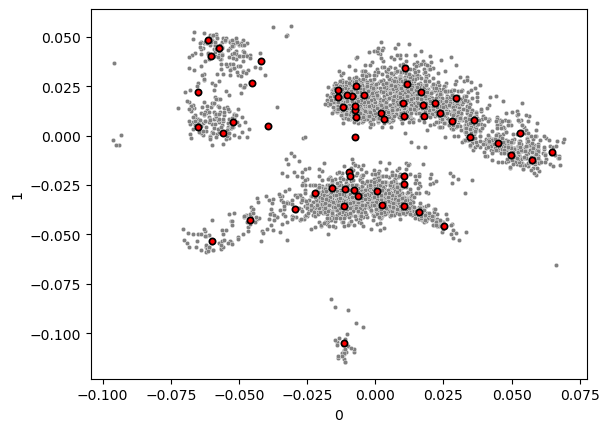

In [10]:
umap = pd.DataFrame(RNA_struct_MOGP.obsm['X_umap']).set_index(RNA_struct_MOGP.obs_names).join(RNA_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_cells = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

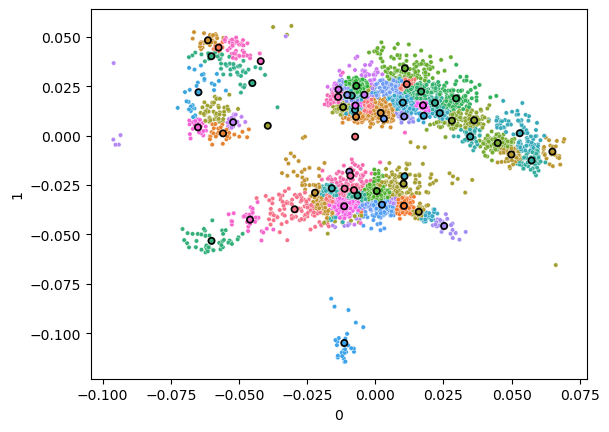

In [11]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_cells,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

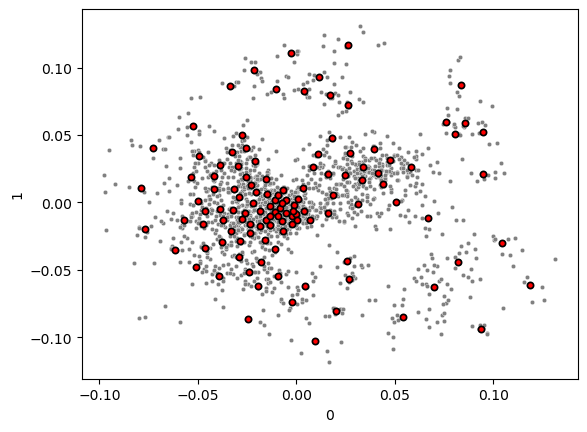

In [12]:
umap = pd.DataFrame(Genes_struct_MOGP.obsm['X_umap']).set_index(Genes_struct_MOGP.obs_names).join(Genes_struct_MOGP.obs['SEACell'])
umap['SEACell'] = umap['SEACell'].astype("category")
mcs_genes = umap.groupby('SEACell').mean().reset_index()
sns.scatterplot(x=0, y=1,
                        color='grey',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                color='red',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/zmoslehi/miniconda3/envs/MOGP-TF-Florian/lib/python3.9/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


<AxesSubplot: xlabel='0', ylabel='1'>

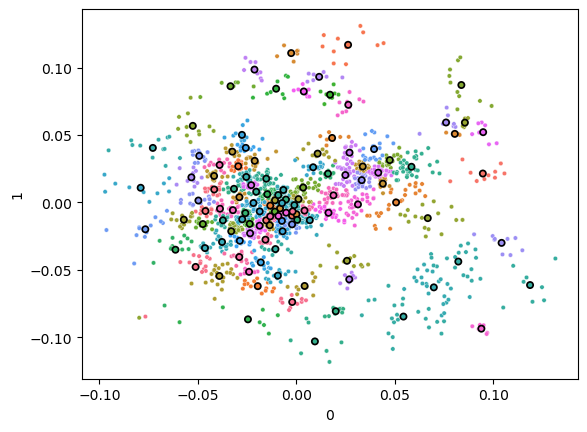

In [13]:
sns.scatterplot(x=0, y=1,
                        hue='SEACell',
                        data=umap,
                        s=10,
                        cmap='Set2',
                        legend=None)
sns.scatterplot(x=0, y=1, s=20,
                hue='SEACell',
                data=mcs_genes,
                cmap='Set2',
                edgecolor='black', linewidth=1.25,
                legend=None)

In [14]:
RNA_struct_MOGP

AnnData object with n_obs × n_vars = 3891 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

In [15]:
Genes_struct_MOGP

AnnData object with n_obs × n_vars = 1734 × 2
    obs: 'SEACell'
    obsm: 'X_umap'

### Standard method

In [16]:
n_neighbors=6
rg_max=100
n_bins=100

In [17]:
#rank_dhatgc = rank_dhatgc_score(RNA_struct_MOGP, Genes_struct_MOGP, RNA_Normalized_2000, n_neighbors)

In [18]:
#title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
#save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/rank_dhatgc_GeneRelevance3.csv' 
#file = open(save_path,'wb')
#pickle.dump(rank_dhatgc,file)
#file.close()

In [19]:
title = 'dim1='+str(dim1)+'  dim2='+str(dim2)+'  dim3='+str(dim3)+'  InducingPoints1='+str(n_inducing_points1)+'  InducingPoints2='+str(n_inducing_points2)+'  BatchSize='+str(batch_size)+'  epochs='+str(num_epochs)+'  emb_reg='+str(emb_reg)+' with_PCA='+str(with_PCA)
save_path = './PBMC5KCITEseqRNA-GPFlux  '+title+'/rank_dhatgc_GeneRelevance3.csv' 
file = open(save_path,'rb')
rank_dhatgc = pickle.load(file)
file.close()

#### gene relevance

In [20]:
LR_gPsi, avg_Psi = LRgPsi_avgPsi_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc, rg_max)

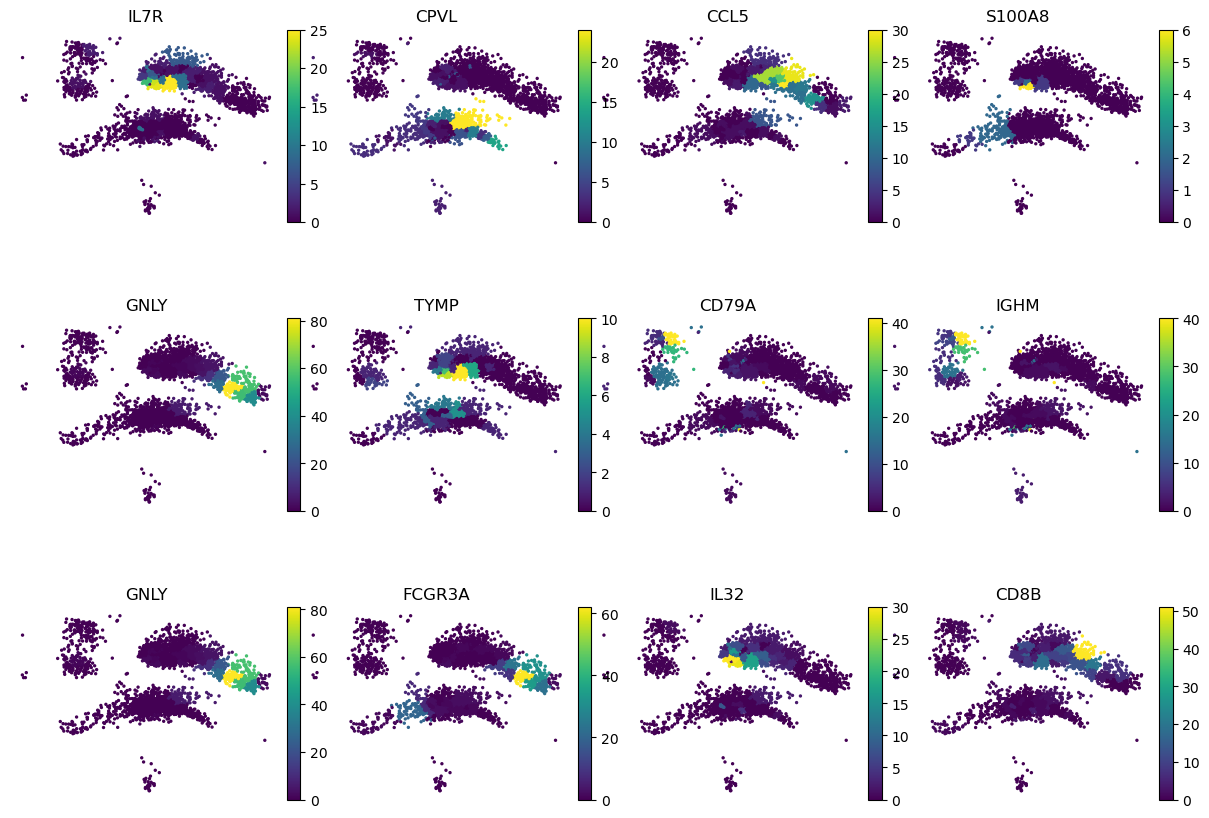

In [21]:
gene_list=["IL7R", "CPVL", "CCL5", "S100A8", "GNLY", "TYMP", "CD79A", "IGHM", "GNLY", "FCGR3A","IL32","CD8B"]
Gene_Relevance_Map(rna, gene_list, LR_gPsi, avg_Psi)

#### Global Meta gene relevance

In [22]:
rank_dhatMetagc = rank_dhatMetagc_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc)

In [23]:
LR_gPsi, avg_Psi, Global_idx = LRgPsi_avgPsi_GlobalMetascore(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatMetagc, rg_max)

In [24]:
mcs_genes_sorted0=mcs_genes[0].values[Global_idx]
mcs_genes_sorted1=mcs_genes[1].values[Global_idx]
mcs_genes_sorted_SEACell=mcs_genes['SEACell'].values[Global_idx]

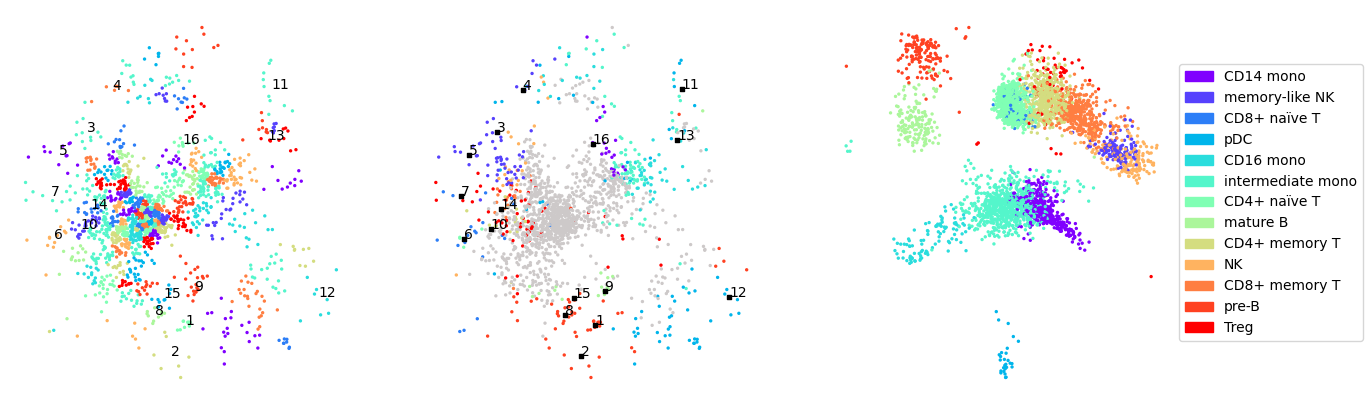

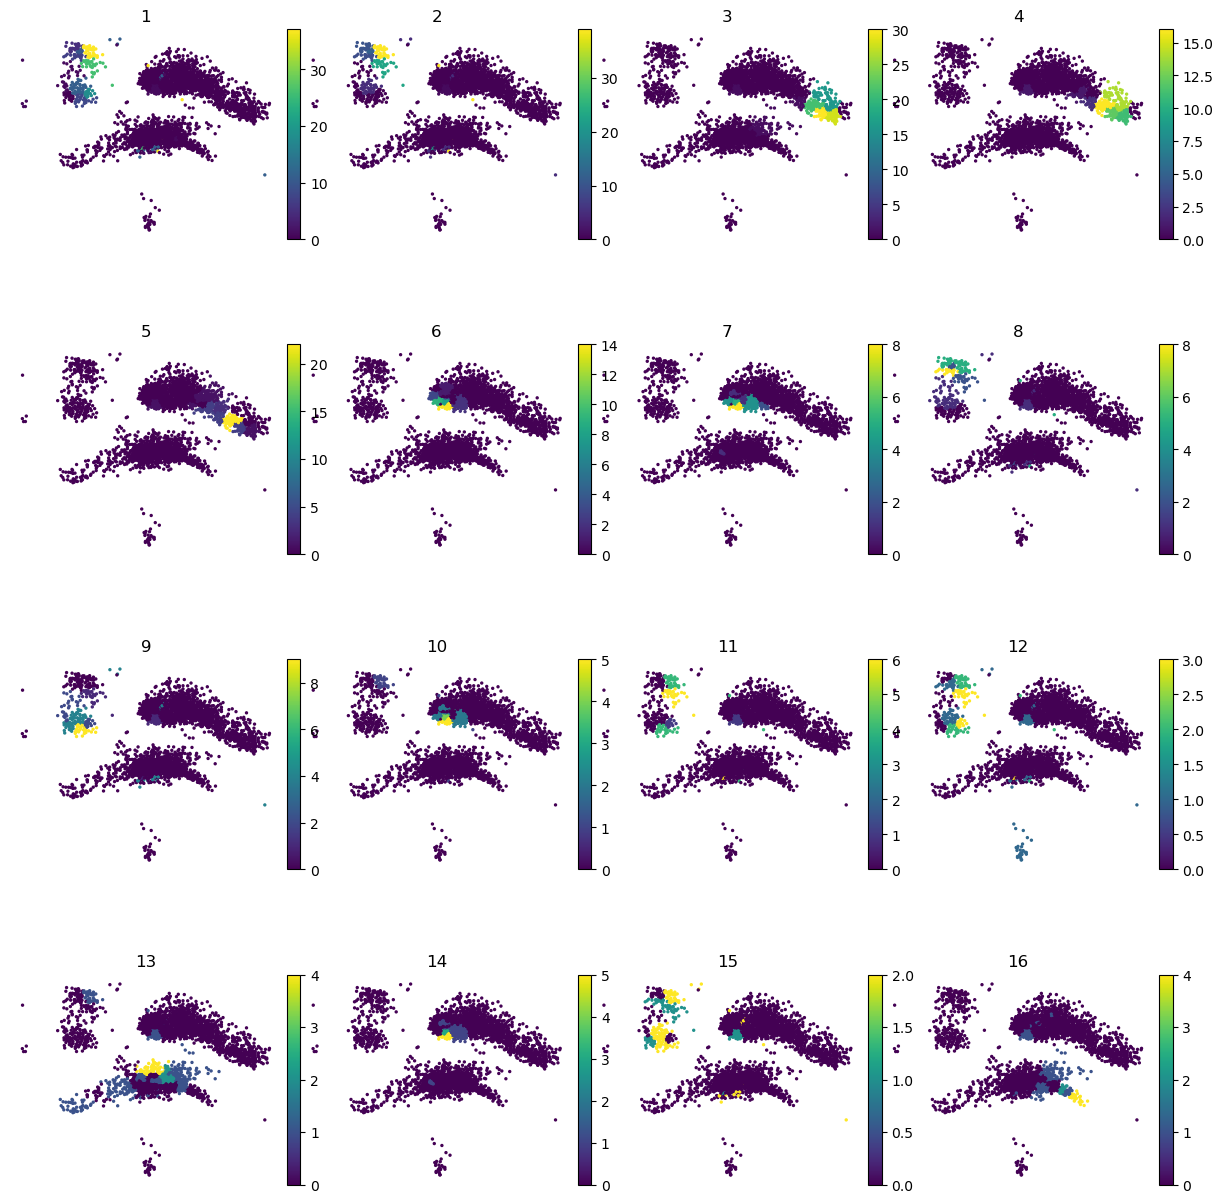

In [25]:
Global_Gene_Relevance_Map_CITE(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=0, topRG=16)

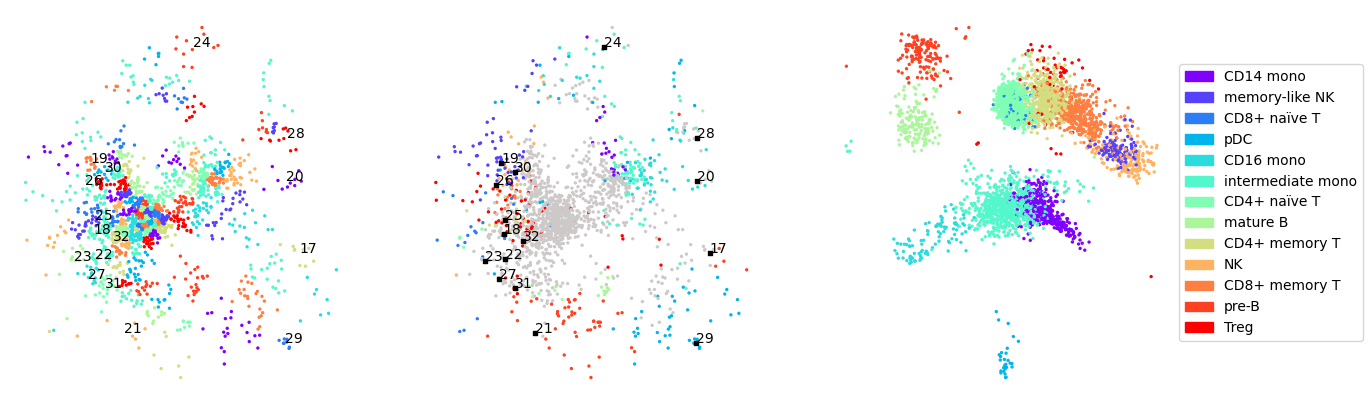

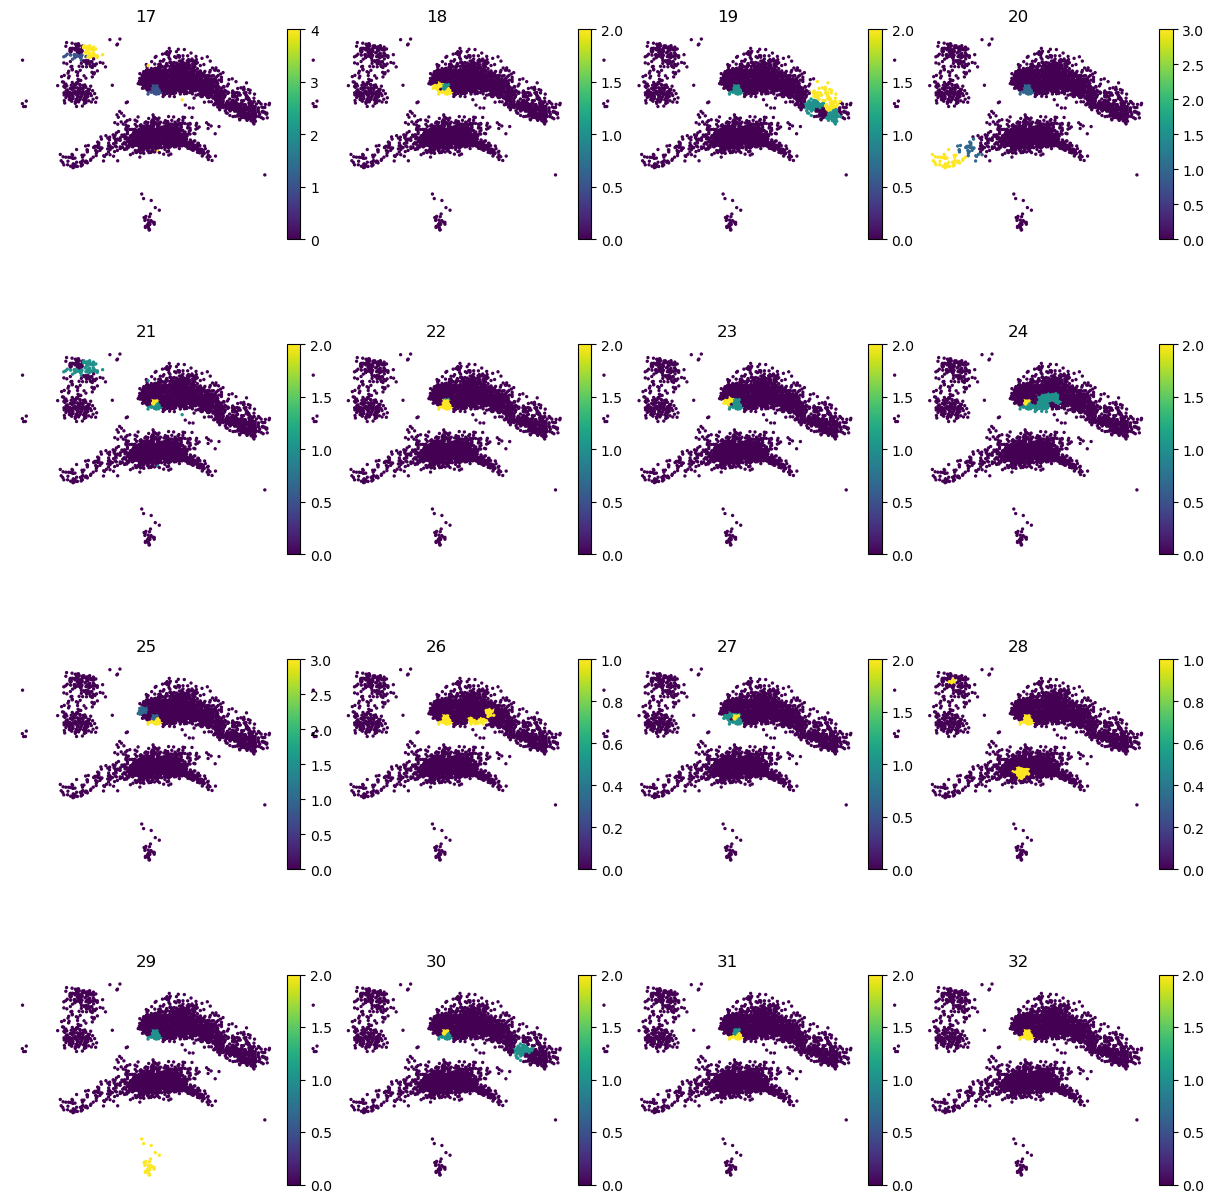

In [26]:
Global_Gene_Relevance_Map_CITE(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=16, topRG=16)

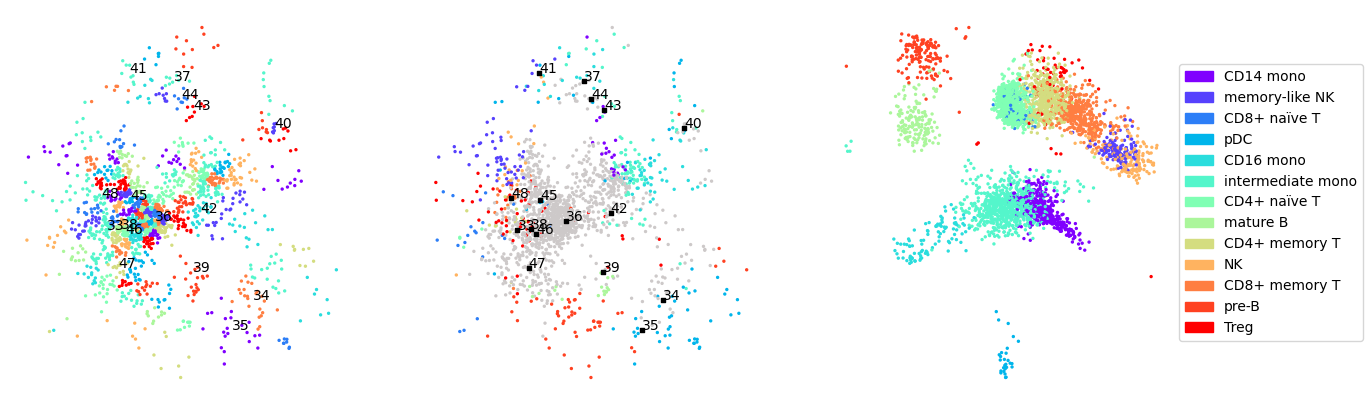

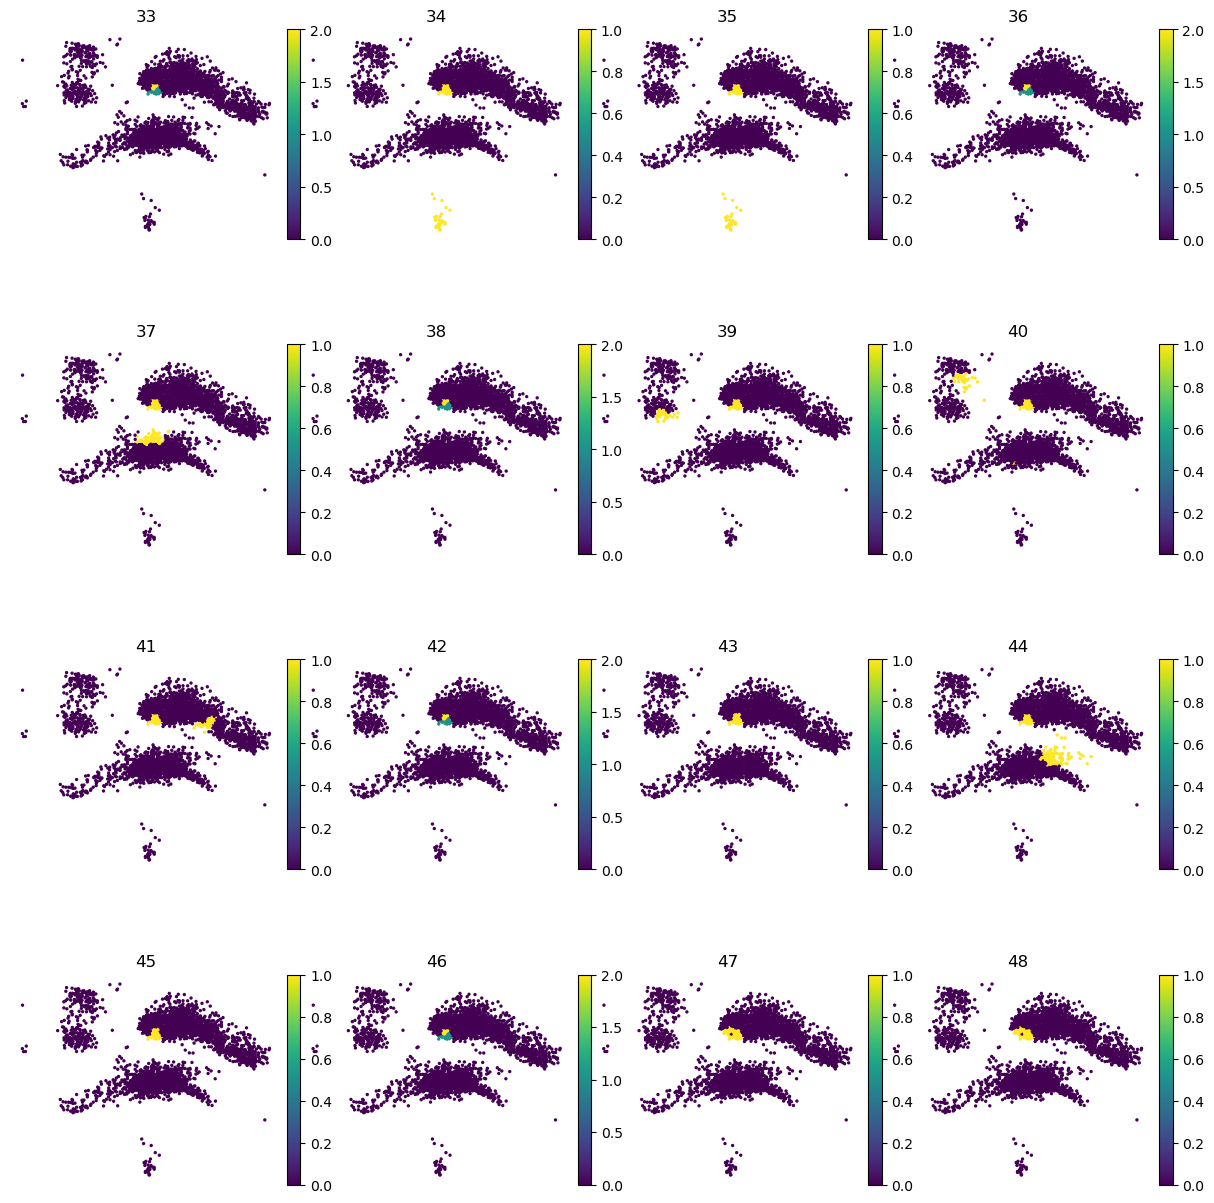

In [27]:
Global_Gene_Relevance_Map_CITE(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0, mcs_genes_sorted1, mcs_genes_sorted_SEACell, LR_gPsi, avg_Psi, offset=32, topRG=16)

#### Merged_Meta_Genes

In [28]:
rank_dhatMetagc = rank_dhatMetagc_score(RNA_struct_MOGP, Genes_struct_MOGP, rank_dhatgc)

In [29]:
[cells,embs1_num]=RNA_struct_MOGP.obsm['X_umap'].shape
metaGenes=rank_dhatMetagc.shape[1]
GR_g=np.zeros(metaGenes)
for g in range(metaGenes):
    nom=np.sum([rank_dhatMetagc[:,g]<=np.repeat(rg_max, cells)])
    s = nom/cells
    GR_g[g]=s  
idx = GR_g.argsort()[-metaGenes:][::-1]
rank_dhatMetagc=rank_dhatMetagc[:,idx]

In [30]:
mcs_genes_sorted0=mcs_genes[0].values[idx]
mcs_genes_sorted1=mcs_genes[1].values[idx]
mcs_genes_sorted_SEACell=mcs_genes['SEACell'].values[idx]


In [31]:
metaGenesList_new=[[0,1,7,20],[14],[8],[5,6,9,13,32,17,21,22,24,31,26,30,31,21,22,26],[25],[2,3,4,18],[19],[12],[15],[28, 33],[35],[37]]

In [32]:
mcs_genes_sorted0_new=[]
mcs_genes_sorted1_new=[]
mcs_genes_sorted_SEACell_new=[]
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[0]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[1]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[2]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[3]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[4]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[5]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[6]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[7]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[8]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[9]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[10]]))
mcs_genes_sorted0_new.append(np.mean(mcs_genes_sorted0[metaGenesList_new[11]]))

mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[0]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[1]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[2]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[3]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[4]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[5]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[6]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[7]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[8]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[9]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[10]]))
mcs_genes_sorted1_new.append(np.mean(mcs_genes_sorted1[metaGenesList_new[11]]))

mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[0]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[1]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[2]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[3]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[4]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[5]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[6]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[7]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[8]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[9]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[10]])
mcs_genes_sorted_SEACell_new.append(mcs_genes_sorted_SEACell[metaGenesList_new[11]])

In [33]:
LR_gPsi, avg_Psi = LRgPsi_avgPsi_MergedMetascore(RNA_struct_MOGP, Genes_struct_MOGP, metaGenesList_new, rank_dhatMetagc, rg_max)

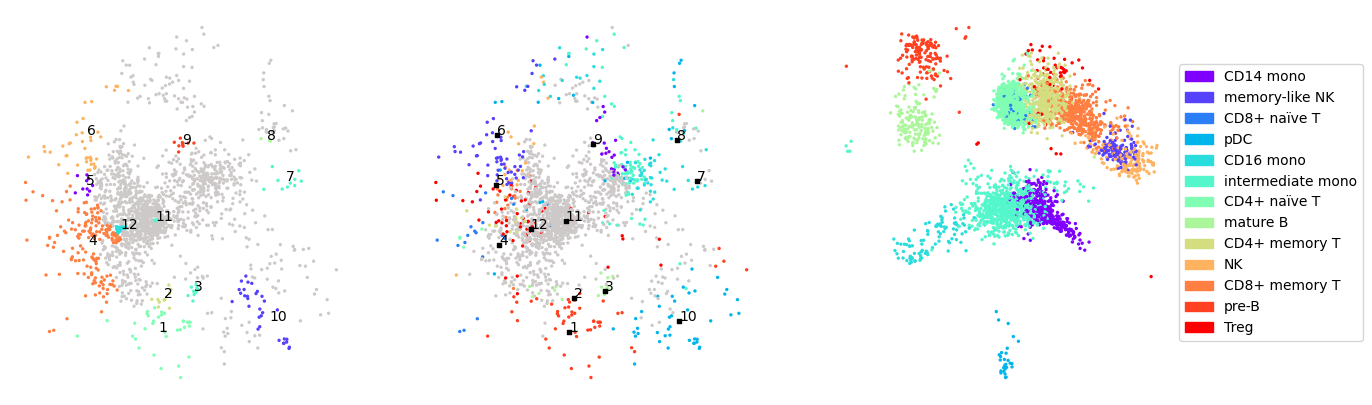

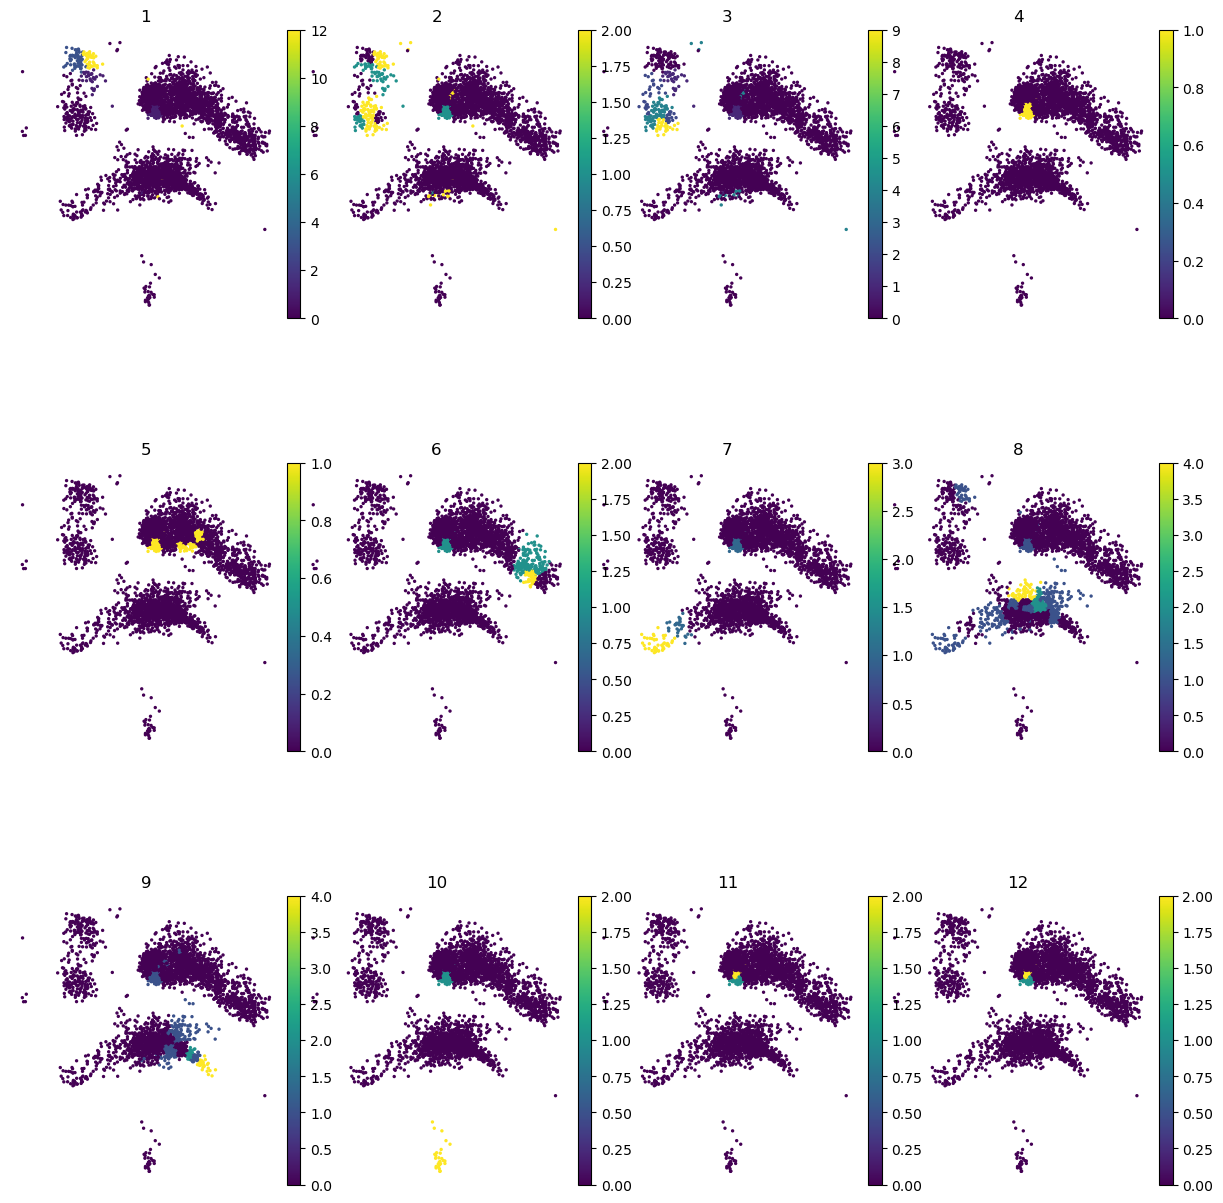

In [34]:
Global_Gene_Relevance_Map_CITE(rna, RNA_struct_MOGP, Genes_struct_MOGP, col_dict1, mcs_genes_sorted0_new, mcs_genes_sorted1_new, mcs_genes_sorted_SEACell_new, LR_gPsi, avg_Psi, offset=0, topRG=12)

#### GEA: Over-representation analysis

In [35]:
gene_sets_all = os.path.join(data_folder_path,  "h.all.v2023.1.Hs.symbols.gmt")
gene_sets_CellType = os.path.join(data_folder_path,  "c8.all.v2023.1.Hs.symbols.gmt")
GEA(rna, RNA_struct_MOGP, Genes_struct_MOGP, mcs_genes_sorted_SEACell_new, gene_sets_all, gene_sets_CellType)

2024-06-04 12:06:24,448 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:24,471 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 1


2024-06-04 12:06:25,252 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:25,254 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:25,404 [INFO] Run: gs_ind_2 
2024-06-04 12:06:25,511 [INFO] Done.


Enrichment_CellType:


Gene_set                               Term Overlap       P-value  \
113  gs_ind_2  HAY_BONE_MARROW_FOLLICULAR_B_CELL   17/69  1.450893e-16   
107  gs_ind_2       HAY_BONE_MARROW_CD34_POS_CLP     1/1  1.903114e-02   

     Adjusted P-value  Odds Ratio  Combined Score  \
113      6.470982e-15   25.416394      926.915115   
107      1.632286e-01   53.338462      211.309841   

                                                 Genes  
113  TNFRSF13C;LINC00926;BANK1;MS4A1;ADAM28;HLA-DOB...  
107                                              CD200

2024-06-04 12:06:25,532 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:25,551 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 2


2024-06-04 12:06:26,351 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:26,354 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:26,432 [INFO] Run: gs_ind_2 
2024-06-04 12:06:26,500 [INFO] Done.


Enrichment_CellType:


Gene_set                               Term Overlap       P-value  \
60  gs_ind_2  HAY_BONE_MARROW_FOLLICULAR_B_CELL    8/69  1.769779e-10   
59  gs_ind_2    HAY_BONE_MARROW_CD34_POS_PRE_PC    1/12  6.725762e-02   

    Adjusted P-value  Odds Ratio  Combined Score  \
60      1.300787e-08   81.477698     1829.581417   
59      2.955337e-01   21.757895       58.729453   

                                                Genes  
60  PNOC;P2RX5;BACE2;TLR10;FCRL2;CD19;ARHGAP24;FCGR2B  
59                                               EBF1

2024-06-04 12:06:26,516 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:26,534 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 3


2024-06-04 12:06:27,317 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:27,319 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:27,405 [INFO] Run: gs_ind_2 
2024-06-04 12:06:27,474 [INFO] Done.


Enrichment_CellType:


Gene_set                               Term Overlap   P-value  \
49  gs_ind_2        HAY_BONE_MARROW_PLASMA_CELL    3/22  0.000201   
48  gs_ind_2  HAY_BONE_MARROW_FOLLICULAR_B_CELL    4/69  0.000403   

    Adjusted P-value  Odds Ratio  Combined Score  \
49          0.006769   35.518519      302.329586   
48          0.010172   16.590481      129.686813   

                              Genes  
49                IGHA1;IGHG1;IGHG3  
48  TNFRSF13B;OSBPL10;BLK;LINC01781

2024-06-04 12:06:27,507 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:27,527 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 4


2024-06-04 12:06:28,300 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:28,303 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:28,502 [INFO] Run: gs_ind_2 
2024-06-04 12:06:28,699 [INFO] Done.


Enrichment_CellType:


Gene_set                           Term  Overlap       P-value  \
283  gs_ind_2   HAY_BONE_MARROW_NAIVE_T_CELL  100/133  1.767239e-84   
286  gs_ind_2  HAY_BONE_MARROW_PRE_DENDRITIC      1/1  1.003460e-01   

     Adjusted P-value  Odds Ratio  Combined Score  \
283      9.719812e-82   16.182867     3120.829169   
286      4.799158e-01    9.991354       22.971431   

                                                 Genes  
283  TRBC1;STMN3;ITK;ANO9;FBLN5;LINC00861;SLC38A1;S...  
286                                               AREG

2024-06-04 12:06:28,719 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:28,736 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 5


2024-06-04 12:06:29,530 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:29,532 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:29,597 [INFO] Run: gs_ind_2 
2024-06-04 12:06:29,651 [INFO] Done.


Enrichment_CellType:


Gene_set                        Term Overlap   P-value  Adjusted P-value  \
53  gs_ind_2    HAY_BONE_MARROW_NK_CELLS   7/152  0.000003          0.000084   
51  gs_ind_2  HAY_BONE_MARROW_CD8_T_CELL    2/43  0.023830          0.064592   

    Odds Ratio  Combined Score                                     Genes  
53   22.236534      280.389892  PTPN4;PYHIN1;ZAP70;CD7;KLRB1;SAMD3;PRKCH  
51   11.436782       42.737024                               SYNE2;KLRG1

2024-06-04 12:06:29,667 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:29,685 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 6


2024-06-04 12:06:30,466 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:30,468 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:30,631 [INFO] Run: gs_ind_2 
2024-06-04 12:06:30,746 [INFO] Done.


Enrichment_CellType:


Gene_set                        Term Overlap       P-value  \
153  gs_ind_2    HAY_BONE_MARROW_NK_CELLS  35/152  3.328437e-32   
149  gs_ind_2  HAY_BONE_MARROW_CD8_T_CELL    2/43  2.797462e-01   

     Adjusted P-value  Odds Ratio  Combined Score  \
153      4.776308e-30   49.118033     3560.085824   
149      7.706226e-01    2.400312        3.057692   

                                                 Genes  
153  NCAM1;GZMA;APOBEC3G;GZMM;TRDC;NKG7;APMAP;TTC38...  
149                                          CCL5;GZMH

2024-06-04 12:06:30,765 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:30,793 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 7


2024-06-04 12:06:31,569 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:31,571 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:31,681 [INFO] Run: gs_ind_2 
2024-06-04 12:06:31,781 [INFO] Done.


Enrichment_CellType:


Gene_set                      Term Overlap       P-value  \
76  gs_ind_2  HAY_BONE_MARROW_MONOCYTE    9/75  3.170360e-12   

    Adjusted P-value  Odds Ratio  Combined Score  \
76      4.723836e-10  139.207506     3685.821622   

                                                Genes  
76  CDKN1C;CTSL;TCF7L2;HES4;LYPD2;C1QA;C1QB;CKB;SI...

2024-06-04 12:06:31,798 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:31,816 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 8


2024-06-04 12:06:32,599 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:32,601 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:32,653 [INFO] Run: gs_ind_2 
2024-06-04 12:06:32,697 [INFO] Done.


Enrichment_CellType:


Gene_set                                 Term Overlap   P-value  \
27  gs_ind_2             HAY_BONE_MARROW_MONOCYTE    2/75  0.005385   
26  gs_ind_2  HAY_BONE_MARROW_IMMATURE_NEUTROPHIL    1/58  0.097081   

    Adjusted P-value  Odds Ratio  Combined Score        Genes  
27          0.065697   36.633554      191.378478  PIK3AP1;LYN  
26          0.150513   17.194872       40.102024         NPC2

2024-06-04 12:06:32,713 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:32,733 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 9


2024-06-04 12:06:33,517 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:33,519 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:33,603 [INFO] Run: gs_ind_2 
2024-06-04 12:06:33,660 [INFO] Done.


Enrichment_CellType:


Gene_set                        Term Overlap   P-value  Adjusted P-value  \
54  gs_ind_2  HAY_BONE_MARROW_NEUTROPHIL   7/163  0.000002          0.000064   
55  gs_ind_2     HAY_BONE_MARROW_STROMAL    1/43  0.202702          0.324920   

    Odds Ratio  Combined Score                                    Genes  
54   28.834862      382.078939  DYSF;MCEMP1;PADI4;QPCT;CES1;STEAP4;VNN2  
55    6.862069       10.951983                                   CYP1B1

2024-06-04 12:06:33,676 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:33,694 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 10


2024-06-04 12:06:34,474 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:34,476 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:34,601 [INFO] Run: gs_ind_2 
2024-06-04 12:06:34,717 [INFO] Done.


Enrichment_CellType:


Gene_set                            Term Overlap       P-value  \
145  gs_ind_2  HAY_BONE_MARROW_DENDRITIC_CELL   17/62  4.582462e-18   
149  gs_ind_2         HAY_BONE_MARROW_STROMAL    2/43  1.781076e-01   

     Adjusted P-value  Odds Ratio  Combined Score  \
145      4.490813e-16   32.296552     1289.417067   
149      5.359162e-01    3.295344        5.685679   

                                                 Genes  
145  TRAF4;SCT;ZFAT;UGCG;LILRA4;LINC00996;IL3RA;SLC...  
149                                         GAS6;GPM6B

2024-06-04 12:06:34,734 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:34,752 [INFO] Input dict object named with gs_ind_2


Top relenance Gene: 11


2024-06-04 12:06:35,527 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:35,529 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:35,557 [INFO] Run: gs_ind_2 
2024-06-04 12:06:35,576 [INFO] Done.
2024-06-04 12:06:35,582 [INFO] User defined gene sets is given: ../../../data/c8.all.v2023.1.Hs.symbols.gmt
2024-06-04 12:06:35,601 [INFO] Input dict object named with gs_ind_2


Enrichment_CellType:
Top relenance Gene: 12


2024-06-04 12:06:36,387 [WARNING] Input library not found: unknown. Skip
2024-06-04 12:06:36,389 [INFO] Run: c8.all.v2023.1.Hs.symbols.gmt 
2024-06-04 12:06:36,470 [INFO] Run: gs_ind_2 
2024-06-04 12:06:36,530 [INFO] Done.


Enrichment_CellType:


Gene_set                         Term Overlap   P-value  Adjusted P-value  \
38  gs_ind_2  HAY_BONE_MARROW_PLASMA_CELL    1/22  0.206242          0.619792   
39  gs_ind_2        HAY_BONE_MARROW_PRO_B    1/30  0.270728          0.619792   

    Odds Ratio  Combined Score  Genes  
38    6.523810       10.299177  CCR10  
39    4.790164        6.259027  RTKN2

Meta Gene                                 Term Adjusted P-value  \
113          1    HAY_BONE_MARROW_FOLLICULAR_B_CELL              0.0   
107          1         HAY_BONE_MARROW_CD34_POS_CLP         0.163229   
60           2    HAY_BONE_MARROW_FOLLICULAR_B_CELL              0.0   
59           2      HAY_BONE_MARROW_CD34_POS_PRE_PC         0.295534   
49           3          HAY_BONE_MARROW_PLASMA_CELL         0.006769   
48           3    HAY_BONE_MARROW_FOLLICULAR_B_CELL         0.010172   
283          4         HAY_BONE_MARROW_NAIVE_T_CELL              0.0   
286          4        HAY_BONE_MARROW_PRE_DENDRITIC         0.479916   
53           5             HAY_BONE_MARROW_NK_CELLS         0.000084   
51           5           HAY_BONE_MARROW_CD8_T_CELL         0.064592   
153          6             HAY_BONE_MARROW_NK_CELLS              0.0   
149          6           HAY_BONE_MARROW_CD8_T_CELL         0.770623   
76           7             HAY_BONE_MARROW_MONOCYTE              0.0   
27           8             HAY_BONE_MARROW_MONOCYTE         0.065697   
26           8  HAY_BONE_MARROW_IMMATURE_NEUTROPHIL         0.150513   
54           9           HAY_BONE_MARROW_NEUTROPHIL         0.000064   
55           9              HAY_BONE_MARROW_STROMAL          0.32492   
145         10       HAY_BONE_MARROW_DENDRITIC_CELL              0.0   
149         10              HAY_BONE_MARROW_STROMAL         0.535916   
0           11                                  NaN              NaN   
1           11                                  NaN              NaN   
38          12          HAY_BONE_MARROW_PLASMA_CELL         0.619792   
39          12                HAY_BONE_MARROW_PRO_B         0.619792   

    Combined Score  
113     926.915115  
107     211.309841  
60     1829.581417  
59       58.729453  
49      302.329586  
48      129.686813  
283    3120.829169  
286      22.971431  
53      280.389892  
51       42.737024  
153    3560.085824  
149       3.057692  
76     3685.821622  
27      191.378478  
26       40.102024  
54      382.078939  
55       10.951983  
145    1289.417067  
149       5.685679  
0              NaN  
1              NaN  
38       10.299177  
39        6.259027